In [1]:
# standard input
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.transform import array_bounds
import matplotlib.pyplot as plt
import os
import pyproj
import geopandas as gpd
import time as pytime

In [2]:
# import tools
from src.OpStatsLoader import OpStatsLoader
from src.NetworkRouter import NetworkRouter
from src.VehTrajBuilder import VehTrajBuilder
from src.TrajDrawer import TrajDrawer
from src.PTTrajBuilder import build_pt_trajectory_during_study

In [3]:
study_name = 'sum-wp2_3-deliverable'
nw_name = 'example_network'
gtfs_name = 'example_gtfs'


op_stats_path = os.path.join("data", study_name, "simulation-results", "example_ptbroker", "2-0_op-stats.csv")
nw_path = os.path.join("data", study_name, "networks", nw_name, "base")
background_image_path = os.path.join("data", study_name, "networks", nw_name, "study_area_with_pt.tif")
gtfs_path = os.path.join("data", study_name, "pt", nw_name, gtfs_name, "matched")

save_path = os.path.join("data", study_name, "animations")

In [4]:
study_start_time = 0
study_end_time = 7200
pt_headway = 120
pt_duration = 180
time_step = 10

In [5]:
osl = OpStatsLoader(op_stats_path)

Loaded records for 5 vehicles.


In [6]:
nw = NetworkRouter(nw_path)

Reading node file: data\sum-wp2_3-deliverable\networks\example_network\base\nodes.csv
Read 7617 nodes.
Reading edge file: data\sum-wp2_3-deliverable\networks\example_network\base\edges.csv
Read 11366 edges.
Building network...
Network graph built. Contains 7617 nodes and 11366 edges.


In [7]:
vtb = VehTrajBuilder(nw, nodes_df=nw.get_nodes_df())

fleet_trajectory = vtb.build_fleet_trajectory(osl.get_fleet_stats(), start_time=study_start_time, end_time=study_end_time, time_step=time_step)

The Vehicle Trajectory for vehicle 2 has been built.
The Vehicle Trajectory for vehicle 1 has been built.
The Vehicle Trajectory for vehicle 4 has been built.
The Vehicle Trajectory for vehicle 0 has been built.
The Vehicle Trajectory for vehicle 3 has been built.
The Fleet Trajectory from 0 to 7200 with a time step of 10 has been built.
The Fleet Trajectory contains 5 vehicles.


In [8]:
# load geojson
pt_route_filepath = 'data/sum-wp2_3-deliverable/pt/example_network/example_gtfs/example_pt_route.geojson'
pt_routes = gpd.read_file(pt_route_filepath)

# get line string
route = pt_routes[pt_routes['id'] == 0]['geometry'].values[0]

pt_trajectories = build_pt_trajectory_during_study(route, study_start_time, study_end_time, pt_headway, pt_duration, time_step)
pt_trajectories_reverse = build_pt_trajectory_during_study(route, study_start_time, study_end_time, pt_headway, pt_duration, time_step, reverse=True)

In [9]:
# merge all trajectories in to one dict
# trajectories = {time: 
#                    {
#                      vehicle: [((x, y), occupancy), ...],
#                      pt: [(x, y), ...],
#                      pt_reversed: [(x, y), ...],
#                    }
#                }
time_steps: np.ndarray = np.arange(study_start_time, study_end_time+1, time_step)

trajectories = {}

for time in time_steps:
    current_nodes = {}
    trajectories[time] = []
    vehicle_nodes = []
    for veh_id, veh_trajectory in fleet_trajectory.items():
        if time in veh_trajectory.keys():
            vehicle_nodes.append(veh_trajectory[time])
    current_nodes['vehicle'] = vehicle_nodes
    vehicle_nodes = []

    if time in pt_trajectories.keys():
        current_nodes['pt'] = pt_trajectories[time]

    if time in pt_trajectories_reverse.keys():
        current_nodes['pt_reverse'] = pt_trajectories_reverse[time]

    trajectories[time] = current_nodes

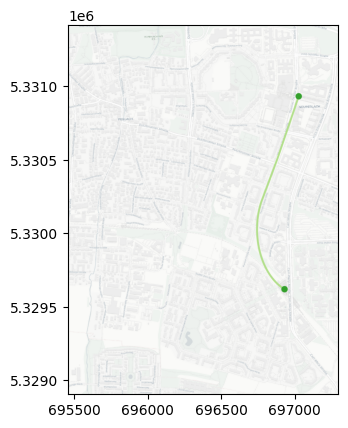


Background Image CRS: EPSG:32632

Bounding Box (left, bottom, right, top): (695458.1772122199, 5328903.711838595, 697298.2728122199, 5331418.384236965)


In [10]:
with rasterio.open(background_image_path) as src:
    bkg_rgb = src.read([1, 2, 3])
    show(bkg_rgb, transform=src.transform)

    bkg_crs = src.crs
    print(f"\nBackground Image CRS: {bkg_crs}")

    bkg_bounds = src.bounds
    bkg_bounding_box = (bkg_bounds.left, bkg_bounds.bottom, bkg_bounds.right, bkg_bounds.top)
    print(f"\nBounding Box (left, bottom, right, top): {bkg_bounding_box}")

In [11]:
nodes_filepath = 'data/sum-wp2_3-deliverable/networks/example_network/base/nodes.csv'
td = TrajDrawer(
    background_image_path=background_image_path,
    bounding_box=bkg_bounding_box,
    pt_color='deepskyblue',
    pt_reversed_color='tomato',
    point_size=40
)

Bounding box set to: (695458.1772122199, 5328903.711838595, 697298.2728122199, 5331418.384236965)


In [12]:
deawing_start_time = pytime.time()
td.draw_trajectory_animation(
    trajectories_data=trajectories,
    output_filepath="./example_animation.mp4",
    interval_ms=100,
    repeat_animation=True
)
print(f"Drawing took {pytime.time() - deawing_start_time} seconds.")

Preparing animation with interval=100ms...
Background image plotted using rasterio.plot.show. CRS: EPSG:32632
Rasterio set ax limits to: X=(np.float64(695458.1772122199), np.float64(697298.2728122199)), Y=(np.float64(5328903.711838595), np.float64(5331418.384236965))
Creating animation with 721 frames...
Saving animation to ./example_animation.mp4...
Animation saved successfully to ./example_animation.mp4


Drawing took 38.366536378860474 seconds.
